## Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from termcolor import colored
import cv2
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_dir = 'Train'
test_dir = 'Test'
val_dir = 'Validation'

### Let's view some of the images of **Train** Dataset

In [3]:
data_train = image_dataset_from_directory(train_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_validation = image_dataset_from_directory(val_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)
data_test = image_dataset_from_directory(test_dir,labels='inferred',
                                       label_mode='binary',interpolation='nearest',image_size=[150,150],batch_size=64,
                                       shuffle=True)


Found 10000 files belonging to 2 classes.
Found 801 files belonging to 2 classes.
Found 992 files belonging to 2 classes.


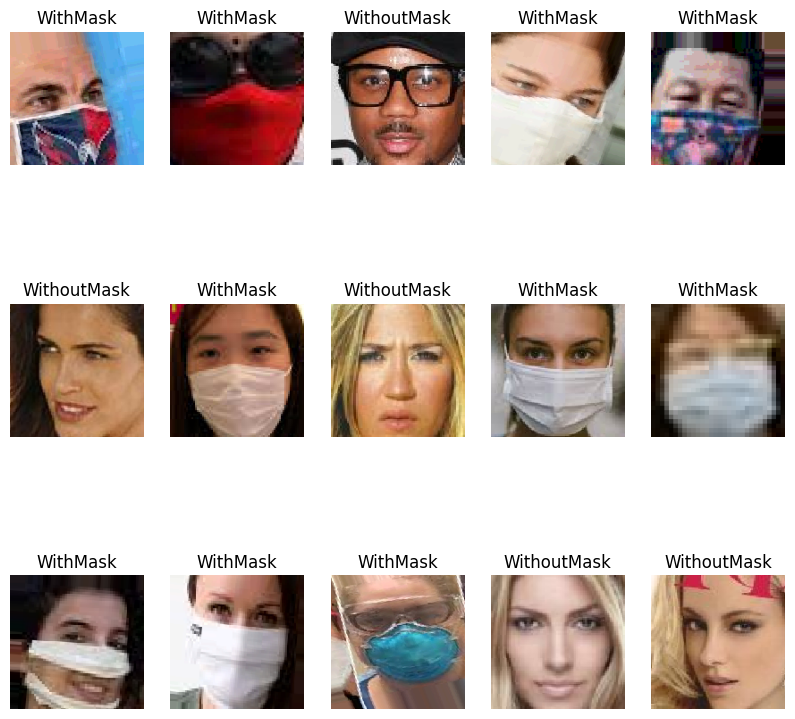

In [4]:
classes_train = data_train.class_names
plt.figure(figsize=(10,10))
for img, label in data_train.take(1):
    for i in range(15):
        ax = plt.subplot(3,5,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.title(classes_train[int(label[i])])
        plt.axis('off')
        
        
# from IPython.display import clear_output
clear_output()

## Data Augmentation

In [5]:
# Image size
IMG_SIZE = (256, 256)

# data argumentation
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                       rotation_range=45,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       vertical_flip=True
                                       )

# data argumentation
test_datagen = ImageDataGenerator(rescale= 1 / 255.0)

train_dataset = train_datagen.flow_from_directory(train_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=200, 
                                         shuffle=True,
                                         class_mode="categorical")

test_dataset = test_datagen.flow_from_directory(test_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

validation_dataset = train_datagen.flow_from_directory(val_dir, target_size=(IMG_SIZE), 
                                         color_mode="rgb",
                                         batch_size=64, 
                                         shuffle=True,
                                         class_mode="categorical")

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 801 images belonging to 2 classes.


## ResNet 50 Base Model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
ResNet= ResNet50(include_top=False,
    weights='imagenet',
    input_shape=(256,256,3),
    classes=2,
    )




94765736/94765736 [==============================] - 37s 0us/step


## Transfer Learning

In [7]:
# Initialize the model in sequential
model = Sequential()
# add MobileNetV2 model into our sequence model
model.add(ResNet)
# flatten the model
model.add(Flatten())
# Adding dense layers
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
# Adding output layer
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 40365314 (153.98 MB)
Trainable params: 40312194 (153.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


## Compile the Model

In [9]:
# model compile
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

## Model Fitting

In [10]:
history = model.fit(train_dataset,
                              validation_data=validation_dataset,
                              epochs=5,
                              verbose=1)

Epoch 1/5




In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
model.evaluate(validation_dataset)

predictions = model.predict(validation_dataset)


y_pred = np.argmax(predictions, axis=1)
y_true = validation_dataset.labels  


conf_matrix = confusion_matrix(y_true, y_pred)


print("Confusion Matrix:")
print(conf_matrix)

13/13 [==============================] - 17s 1s/step
Confusion Matrix:
[[196 204]
 [203 197]]


In [ ]:
predictions = model.predict(validation_dataset)

13/13 [==============================] - 18s 1s/step


In [ ]:
print(predictions.shape)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)
countT =0
countF=0
for predicted_label in predicted_labels:
    if predicted_label == 0:
        countF +=1
    else:
        countT +=1
print(countT,countF)

(800, 2)
[1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 1 0 1 0 0 1 0
 1 1 0 0 1 0 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0
 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1
 0 0 1 0 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 1 0 1 1 0 0 0 0 1 1 1 0 0 0 0 1 1
 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0
 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1
 1 0 1 1 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1
 1 1 1 0 0 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0
 0 0 1 0 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 0 0 0 0 1
 1 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0
 1 1 0 1 1 0 0 0

In [ ]:
real_true=0
real_false=0
for images, labels in data_validation:
    # Iterate through images in the batch
    for label in labels.numpy():
        if label == 0:
            real_false += 1
        else:
            real_true += 1
print(real_true,real_false)
        
        

400 400


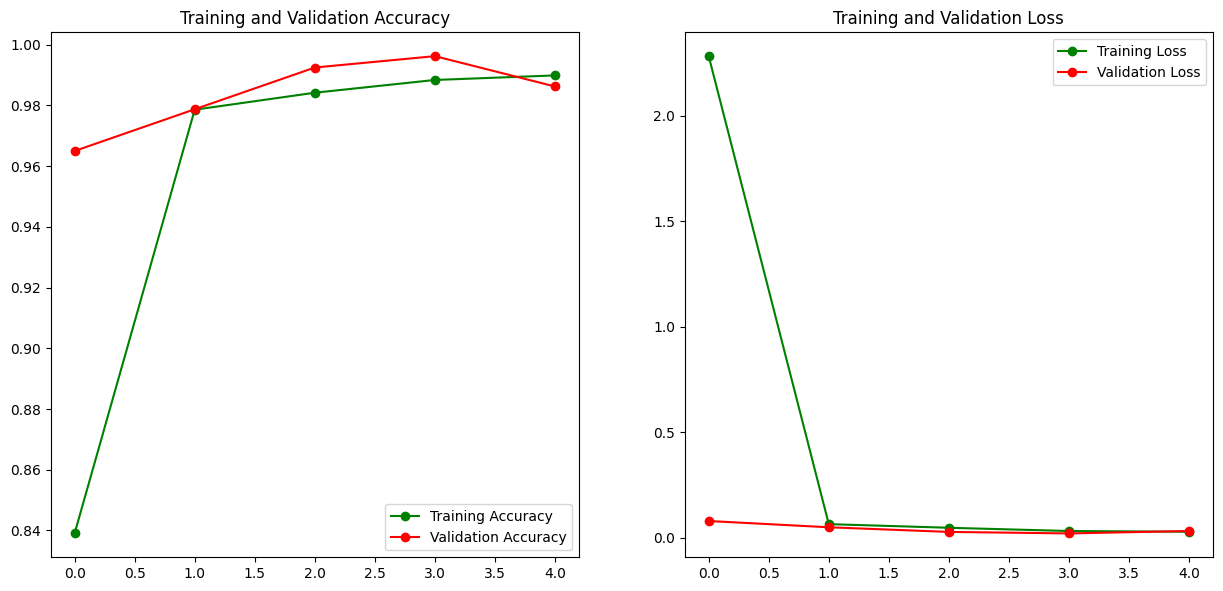

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc,"go-", label='Training Accuracy')
plt.plot(epochs_range, val_acc,"ro-", label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss,"go-", label='Training Loss')
plt.plot(epochs_range, val_loss,"ro-", label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Model Prediction

In [ ]:
test_pred = model.predict(test_dataset)

16/16 [==============================] - 14s 831ms/step


In [ ]:
output = [np.argmax(op) for op in test_pred]
df_output = pd.DataFrame(output)
print(df_output.value_counts())

1    510
0    482
Name: count, dtype: int64


In [ ]:
def img_preprocessing(path):
    sample_mask_img = cv2.imread(path)
    sample_mask_img = cv2.resize(sample_mask_img,(256,256))
    plt.imshow(sample_mask_img)
    sample_mask_img = np.reshape(sample_mask_img,[1,256,256,3])
    sample_mask_img = sample_mask_img/255.0
    res = np.argmax(model.predict(sample_mask_img))
    print('            ', colored(classes_train[res], "red"))

1/1 [==============================] - 0s 52ms/step
             WithoutMask


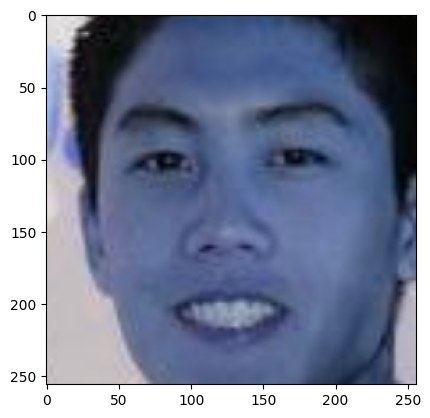

In [ ]:
img_preprocessing('Validation/WithoutMask/5314.png')

1/1 [==============================] - 0s 123ms/step
             WithMask


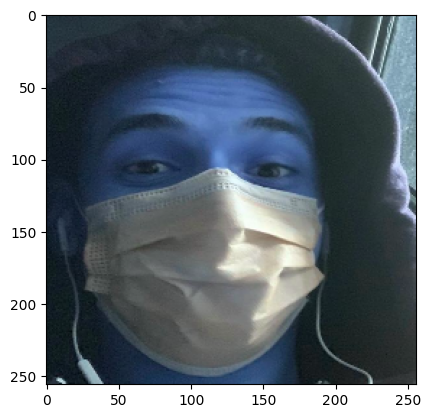

In [ ]:
img_preprocessing('Validation/WithMask/hassan123.png')

1/1 [==============================] - 0s 65ms/step
             WithMask


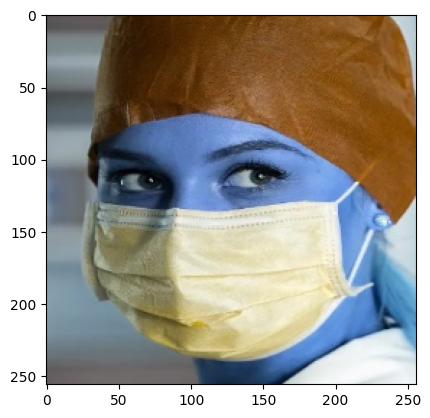

In [ ]:
img_preprocessing('Validation/WithMask/custom1.png')

1/1 [==============================] - 0s 63ms/step
             WithoutMask


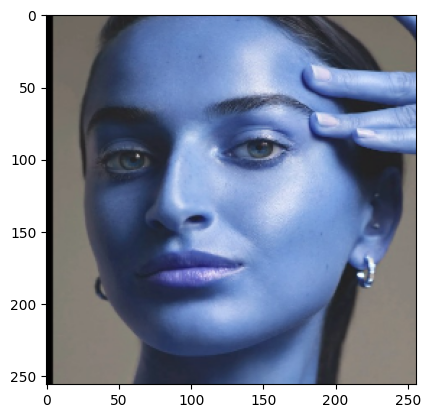

In [ ]:
img_preprocessing('Validation/WithoutMask/custom2.png')